In [32]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

%matplotlib inline

# 1. Data Overview

Feautres description:

- trans_date_trans_time ------- Transaction time stamp

- cc_num ---------------------- Credit card number

- merchant -------------------- Merchant name

- category -------------------- Transaction category

- amt ------------------------- Transaction amount

- first ----------------------- First name of card holder

- last ------------------------ Last name of card holder

- gender ---------------------- Sex of card holder

- street ---------------------- Transaction adress

- city ------------------------ Transaction city

- state ----------------------- Transaction state

- zip ------------------------- Transaction zipcode

- lat ------------------------- Transaction lattitude

- long ------------------------ Transaction longtitude 

- city_pop -------------------- Population of the city

- job ------------------------- Job of the card holder

- dob ------------------------- Date of birth of card holder

- trans_num ------------------- Transaction number of transaction

- unix_time ------------------- Time in unix format

- merch_lat ------------------- Lattitude of the merchant

- merch_long ------------------ Longitude of merchant

- is_fraud -------------------- fraud mark of transaction


In [33]:
# load the dataset
test_trans_data = pd.read_csv('data/fraudTest.csv')
train_trans_data = pd.read_csv('data/fraudTrain.csv')

In [34]:
test_trans_data['mark'] = 'test'
train_trans_data['mark'] = 'train'
# concaeinaton of train and test datasets
trans_data = pd.concat([train_trans_data, test_trans_data]).reset_index()

In [35]:
trans_data = trans_data.drop(trans_data.columns[0:2], axis=1)
trans_data.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,mark
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,train
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,train


In [36]:
trans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   gender                 object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
 22  mark              

# 2. Data processing

In [37]:
# date features transformation
trans_data['trans_date_trans_time'] = pd.to_datetime(trans_data['trans_date_trans_time'])
trans_data['dob'] = pd.to_datetime(trans_data['dob'])

In [38]:
trans_data['trans_month_of_year'] = trans_data['trans_date_trans_time'].dt.month
trans_data['trans_day_of_week'] = trans_data['trans_date_trans_time'].dt.day_of_week
trans_data['trans_hour'] = trans_data['trans_date_trans_time'].dt.hour
trans_data['age_of_cardholder'] = np.round((trans_data['trans_date_trans_time'] - trans_data['dob']) / np.timedelta64(1, 'Y'))

In [39]:
processed_data = trans_data.drop(['trans_date_trans_time'], axis=1)

# 3. Exploratory Data Analysis

## 3.1. Target feature analysis

In [40]:
# Анализ сбалансированности классов целевой переменной
processed_data.is_fraud.value_counts(normalize=True) * 100

0    99.478999
1     0.521001
Name: is_fraud, dtype: float64

In [41]:
# Анализ объемов транзакций в разрезе меток о мощеннически операций
trans_sum  = processed_data[['amt', 'is_fraud']].groupby(['is_fraud']).sum().reset_index().rename(columns={'amt':'trans_sum'})
trans_sum['percentage'] = trans_sum['trans_sum'] / trans_sum['trans_sum'].sum() * 100
trans_sum

,is_fraud,trans_sum,percentage
0,0,1.246639e+08,96.053935
1,1,5.121413e+06,3.946065


Как показывает анализ в данных присутствует дисбаланс классов.
- Классом большинства (можаритарный класс) является - не мошенническая транзакция (99,48% от общего числа транзакций в данных)
- Классом меньшинства (миноритарный класс) является - мошенническая транзакция (0,52% от общего числа транзакций в данных)
- С точки зрения объемов мошеннические операции составляют порядка 4% от общих объемов транзакций.

При построении моделей необходимо использовать различные методы уменьшения влияния дисбаланса на обучение моделей, такие как: взвешивание объектов, выбор порога вероятности, сэмплирование.

## 3.2 Transaction amount feature analysis

In [42]:
# Анализ распределение признака "amt"
overall_amount = processed_data['amt'].describe(percentiles=[0.25, 0.5, 0.75, 0.99]).reset_index().rename(columns={'index':'description', 'amt': 'overall amount'})
is_fraud_amount = processed_data[processed_data['is_fraud'] == 1]['amt'].describe(percentiles=[0.25, 0.5, 0.75, 0.99]).reset_index().rename(columns={'index':'description', 'amt':'is_fraud amount'})
non_fraud_amount = processed_data[processed_data['is_fraud'] == 0]['amt'].describe(percentiles=[0.25, 0.5, 0.75, 0.99]).reset_index().rename(columns={'index':'description', 'amt':'non_fraud amount'})
amount_distribution = pd.concat([overall_amount, is_fraud_amount.drop(['description'], axis=1), non_fraud_amount.drop(['description'], axis=1)], axis=1).reset_index(drop=1)
amount_distribution

,description,overall amount,is_fraud amount,non_fraud amount
0,count,1.852394e+06,9651.000000,1.842743e+06
1,mean,7.006357e+01,530.661412,6.765128e+01
2,std,1.592540e+02,391.028873,1.535481e+02
3,min,1.000000e+00,1.060000,1.000000e+00
4,25%,9.640000e+00,240.075000,9.610000e+00
5,50%,4.745000e+01,390.000000,4.724000e+01
6,75%,8.310000e+01,902.365000,8.256000e+01
7,99%,5.379000e+02,1175.850000,4.849100e+02
8,max,2.894890e+04,1376.040000,2.894890e+04


По результатам анализа распределения признака величины транзкации в зависимости от метки о мошенничестве сделаны следующие выводы:
- Общее количество операций, помеченных как мошеннические, составляет 9651 единица.
- Показатель среднего арифметического для распределения величины мошеннических транзакций на порядок превосходит аналогичных показатель не мошеннических транзакций (530,7 против 67,7).
- Максимальное значение величины мошеннических транзакцией составляет 1376.

Для наглядности визуализации распределения признака величины транзакции в качестве ограничение принято значение 1500.

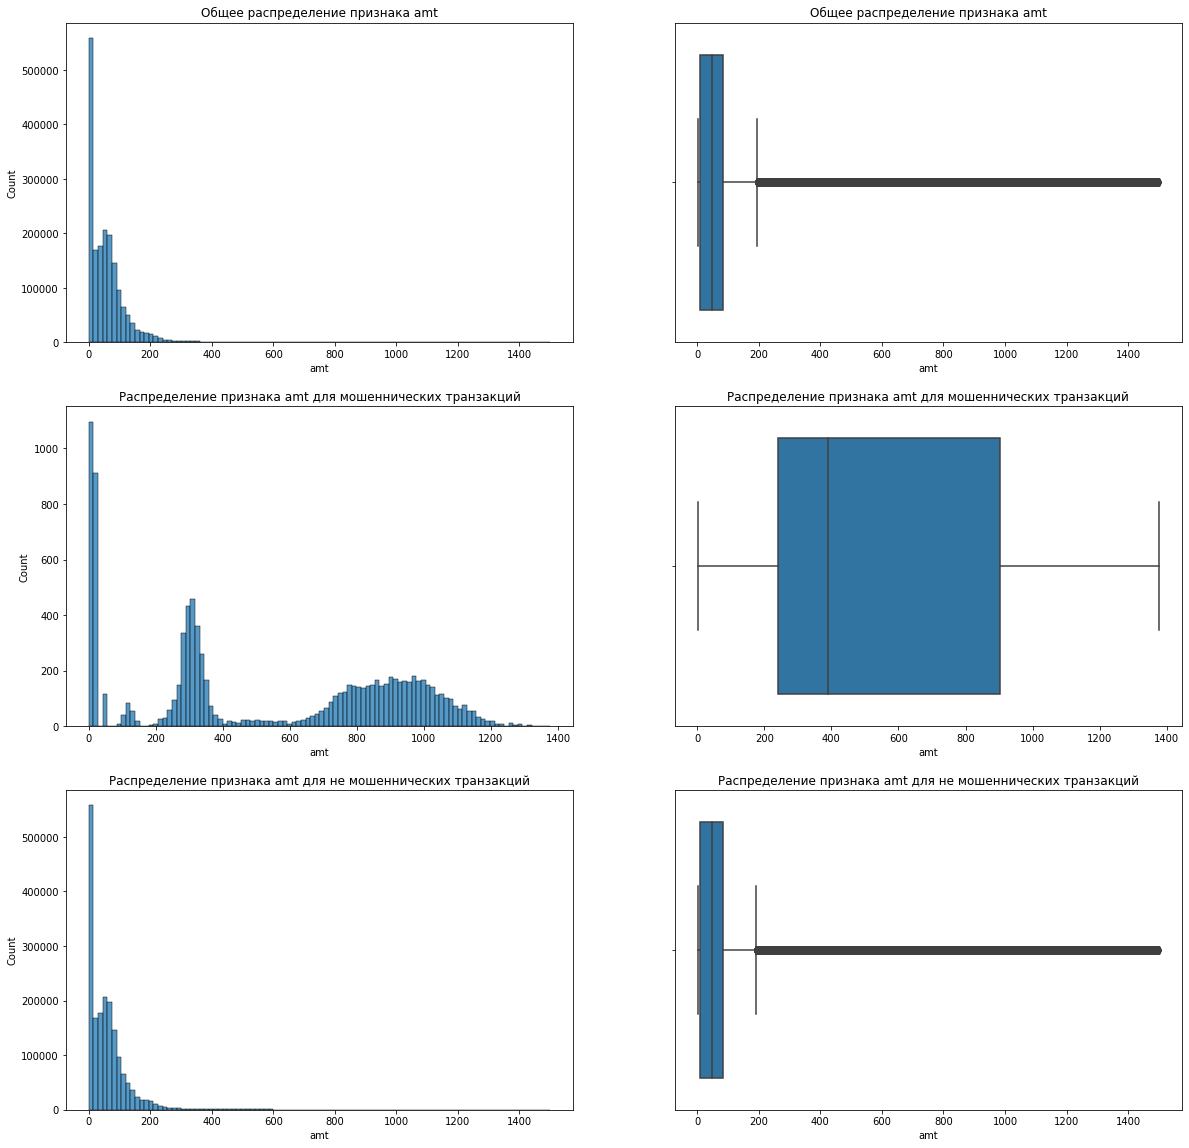

In [43]:
# Построение гистораммы и корбчатой диаграммы для признака "amt"
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
histplot = sns.histplot(data=processed_data[(processed_data.amt <= 1500)], x='amt', ax=axes[0][0], bins=100)
histplot.set_title('Общее распределение признака amt')
boxplot = sns.boxplot(data=processed_data[(processed_data.amt <= 1500)], x='amt', ax=axes[0][1])
boxplot.set_title('Общее распределение признака amt');

histplot = sns.histplot(data=processed_data[(processed_data.amt <= 1500) & (processed_data.is_fraud == 1)], x='amt', ax=axes[1][0], bins=100)
histplot.set_title('Распределение признака amt для мошеннических транзакций')
boxplot = sns.boxplot(data=processed_data[(processed_data.amt <= 1500) & (processed_data.is_fraud == 1)], x='amt', ax=axes[1][1])
boxplot.set_title('Распределение признака amt для мошеннических транзакций');

histplot = sns.histplot(data=processed_data[(processed_data.amt <= 1500) & (processed_data.is_fraud == 0)], x='amt', ax=axes[2][0], bins=100)
histplot.set_title('Распределение признака amt для не мошеннических транзакций')
boxplot = sns.boxplot(data=processed_data[(processed_data.amt <= 1500) & (processed_data.is_fraud == 0)], x='amt', ax=axes[2][1])
boxplot.set_title('Распределение признака amt для не мошеннических транзакций');

По результатам анализа визуализации распределения признака величины транзкации в зависимости от метки о мошенничестве сделаны следующие выводы:
- Основная часть наблюдение признака величины не мошеннических транзакций лежит в пределах от 0 до 100.
- В данных наблюдаются множетсвенные выбросы.
- Распределение мошеннических транзакции более равномерно чем не мошеннических.

## 3.2 Age of card holder feature analysis

In [44]:
# Анализ распределение признака "age_of_cardholder"
overall_age = processed_data['age_of_cardholder'].describe(percentiles=[0.25, 0.5, 0.75, 0.99]).reset_index().rename(columns={'index':'description', 'age_of_cardholder': 'overall age_of_cardholder'})
is_fraud_age = processed_data[processed_data['is_fraud'] == 1]['age_of_cardholder'].describe(percentiles=[0.25, 0.5, 0.75, 0.99]).reset_index().rename(columns={'index':'description', 'age_of_cardholder':'is_fraud age_of_cardholder'})
non_fraud_age = processed_data[processed_data['is_fraud'] == 0]['age_of_cardholder'].describe(percentiles=[0.25, 0.5, 0.75, 0.99]).reset_index().rename(columns={'index':'description', 'age_of_cardholder':'non_fraud age_of_cardholder'})
age_distribution = pd.concat([overall_age, is_fraud_age.drop(['description'], axis=1), non_fraud_age.drop(['description'], axis=1)], axis=1).reset_index(drop=1)
age_distribution

,description,overall age_of_cardholder,is_fraud age_of_cardholder,non_fraud age_of_cardholder
0,count,1.852394e+06,9651.000000,1.842743e+06
1,mean,4.626617e+01,48.837115,4.625271e+01
2,std,1.741239e+01,18.613483,1.740488e+01
3,min,1.400000e+01,14.000000,1.400000e+01
4,25%,3.300000e+01,33.000000,3.300000e+01
5,50%,4.400000e+01,48.000000,4.400000e+01
6,75%,5.700000e+01,61.000000,5.700000e+01
7,99%,9.200000e+01,92.000000,9.200000e+01
8,max,9.600000e+01,96.000000,9.600000e+01


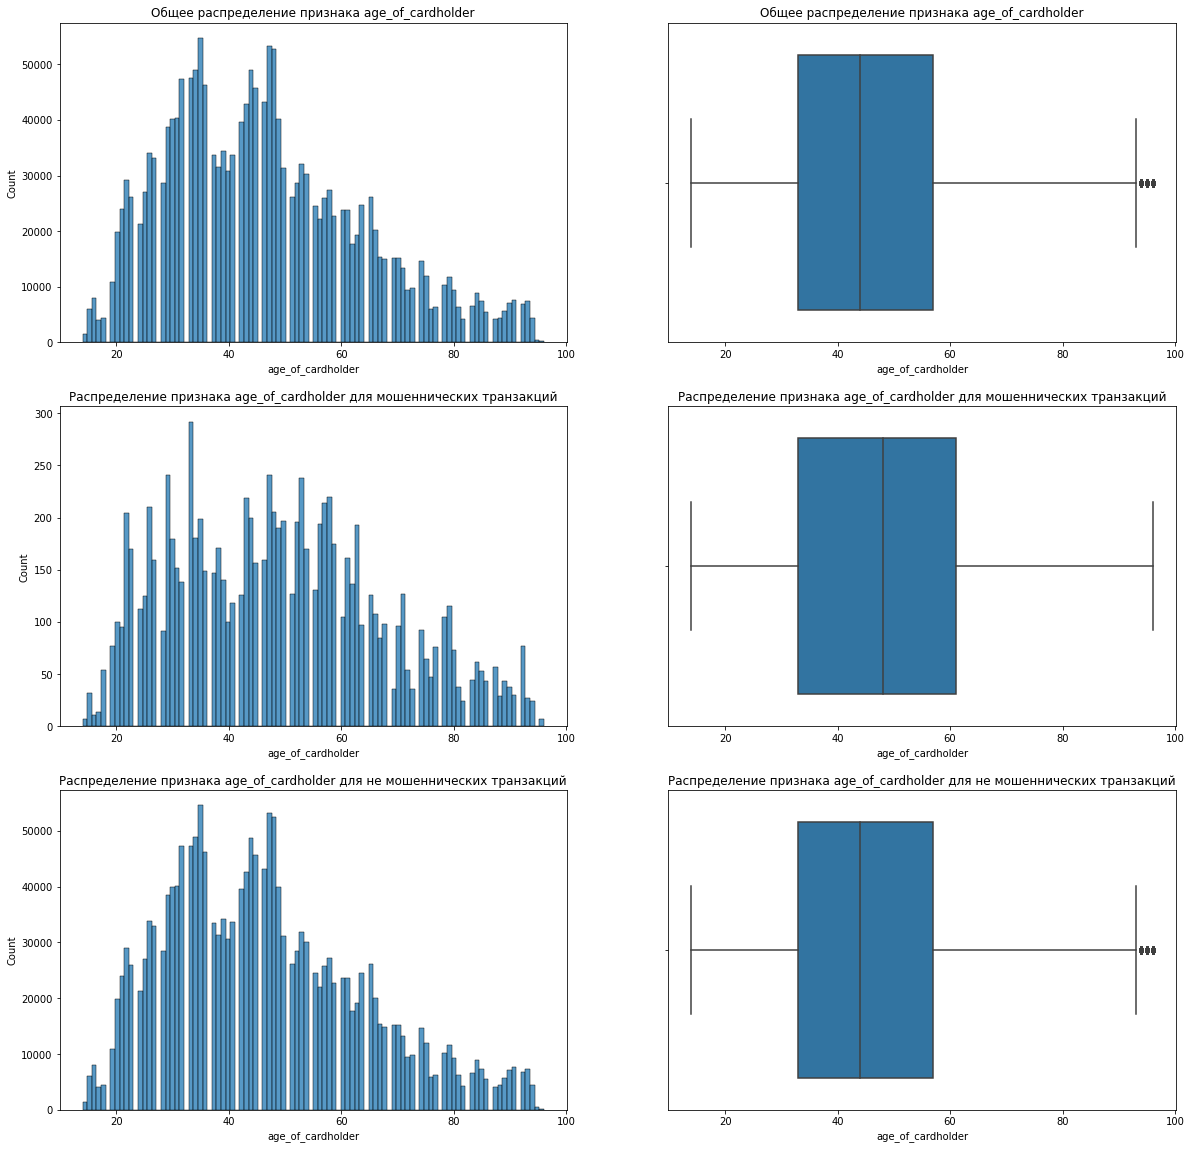

In [45]:
# Построение гистораммы и корбчатой диаграммы для признака "age_of_cardholder"
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
histplot = sns.histplot(data=processed_data, x='age_of_cardholder', ax=axes[0][0], bins=100)
histplot.set_title('Общее распределение признака age_of_cardholder')
boxplot = sns.boxplot(data=processed_data, x='age_of_cardholder', ax=axes[0][1])
boxplot.set_title('Общее распределение признака age_of_cardholder');

histplot = sns.histplot(data=processed_data[processed_data.is_fraud == 1], x='age_of_cardholder', ax=axes[1][0], bins=100)
histplot.set_title('Распределение признака age_of_cardholder для мошеннических транзакций')
boxplot = sns.boxplot(data=processed_data[processed_data.is_fraud == 1], x='age_of_cardholder', ax=axes[1][1])
boxplot.set_title('Распределение признака age_of_cardholder для мошеннических транзакций');

histplot = sns.histplot(data=processed_data[processed_data.is_fraud == 0], x='age_of_cardholder', ax=axes[2][0], bins=100)
histplot.set_title('Распределение признака age_of_cardholder для не мошеннических транзакций')
boxplot = sns.boxplot(data=processed_data[processed_data.is_fraud == 0], x='age_of_cardholder', ax=axes[2][1])
boxplot.set_title('Распределение признака age_of_cardholder для не мошеннических транзакций');

In [46]:
# Выполним группировку владельцев карты по группам возраста
def get_age_group(age):
    if age <= 30:
        return '< 30'
    elif age > 30 and age <= 45:
        return '30-45'
    elif age > 45 and age <= 60:
        return '45-60'
    else:
        return '> 60'


processed_data['age_group'] = processed_data['age_of_cardholder'].apply(get_age_group)

In [47]:
# Сгруппируем данные по возрастным группам
overal_age_grouped = processed_data[['age_group', 'trans_num']].groupby(['age_group']).count().reset_index().rename(columns={'trans_num':'trans_count'})
fraud_age_grouped = processed_data[['age_group', 'trans_num', 'is_fraud']].groupby(['age_group', 'is_fraud']).count().reset_index().rename(columns={'trans_num':'fraud trans_count'})
merged_age_grouped = fraud_age_grouped.merge(overal_age_grouped, how='inner', on='age_group')
merged_age_grouped['percentage'] = merged_age_grouped['fraud trans_count'] / merged_age_grouped['trans_count'] * 100
merged_age_grouped

,age_group,is_fraud,fraud trans_count,trans_count,percentage
0,30-45,0,624194,626681,99.603147
1,30-45,1,2487,626681,0.396853
2,45-60,0,481947,484709,99.430174
3,45-60,1,2762,484709,0.569826
4,< 30,0,355435,357316,99.473575
5,< 30,1,1881,357316,0.526425
6,> 60,0,381167,383688,99.342956
7,> 60,1,2521,383688,0.657044


По результатам анализа распределения признака возвраста владельца карты в зависимости от метки о мошенничестве сделаны следующие выводы:
- Среднее значение возвраста владельцев карт мошеннических транзакций больше среднего значений владельцев карт не мошеннических транзакций (48.8 против 46.3 лет)
- Наибольший процент мошеннических транзакций наблюдается в возрастной группе более 60 лет (0.66% от общего числа транзакций по группе).
- Наименьший процент мошеннических транзакций наблюдается в возрастной группе от 30 до 45 лет (0.4% от общего числа транзакций по группе).
- В целом распределение дол мошеннических транзакций по возрастным группам равномерное.

## 3.2 Gender of card holder feature analysis

In [53]:
# Анализ распределения признака 'gender'
overal_gender_grouped = processed_data[['gender', 'trans_num']].groupby(['gender']).count().reset_index().rename(columns={'trans_num':'trans_count'})
fraud_gender_grouped = processed_data[['gender', 'trans_num', 'is_fraud']].groupby(['gender', 'is_fraud']).count().reset_index().rename(columns={'trans_num':'fraud trans_count'})
merged_gender_grouped = fraud_gender_grouped.merge(overal_gender_grouped, how='inner', on='gender')
merged_gender_grouped['percentage'] = merged_gender_grouped['fraud trans_count'] / merged_gender_grouped['trans_count'] * 100
merged_gender_grouped

,gender,is_fraud,fraud trans_count,trans_count,percentage
0,F,0,1009850,1014749,99.517221
1,F,1,4899,1014749,0.482779
2,M,0,832893,837645,99.432695
3,M,1,4752,837645,0.567305


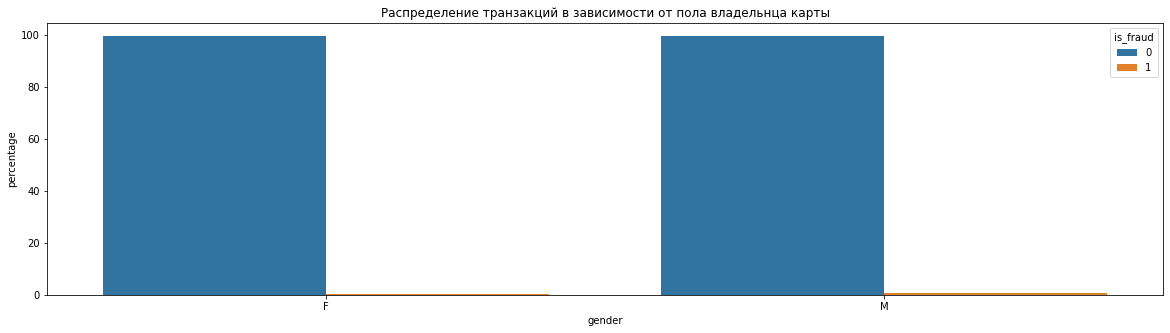

In [60]:
# Построение диаграммы для признака "gender"
fig, axes = plt.subplots(figsize=(20, 5))
barplot = sns.barplot(data=merged_gender_grouped, x='gender', y='percentage', hue='is_fraud', ax=axes)
axes.set_title('Распределение транзакций в зависимости от пола владельнца карты');

По результатам анализа распределения признака пола владельца карты в зависимости от метки о мошенничестве сделаны следующие выводы:
- Наибольший процент мошеннических транзакций наблюдается в группе мужчин (0.57% от общего числа транзакций по группе).
- Мужчины более вовлечены в мошеннические операции (процент мошеннических операций на 16,7% больше чем в женской группе).

## 3.2 Job feature analysis

In [63]:
processed_data.job.describe()

count               1852394
unique                  497
top       Film/video editor
freq                  13898
Name: job, dtype: object

In [114]:
# Анализ признака 'job'
overal_job_grouped = processed_data[['job', 'trans_num']].groupby(['job']).count().reset_index().rename(columns={'trans_num':'trans_count'})
fraud_job_grouped = processed_data[['job', 'trans_num', 'is_fraud']].groupby(['job', 'is_fraud']).count().reset_index().rename(columns={'trans_num':'fraud trans_count'})
merged_job_grouped = fraud_job_grouped.merge(overal_job_grouped, how='inner', on='job')
merged_job_grouped['percentage'] = merged_job_grouped['fraud trans_count'] / merged_job_grouped['trans_count'] * 100
merged_job_grouped

,job,is_fraud,fraud trans_count,trans_count,percentage
0,Academic librarian,0,1456,1467,99.250170
1,Academic librarian,1,11,1467,0.749830
2,"Accountant, chartered",1,11,11,100.000000
3,"Accountant, chartered certified",0,730,751,97.203728
4,"Accountant, chartered certified",1,21,751,2.796272
...,...,...,...,...,...
964,Web designer,1,18,3662,0.491535
965,Wellsite geologist,0,3637,3669,99.127828
966,Wellsite geologist,1,32,3669,0.872172
967,Writer,0,726,741,97.975709


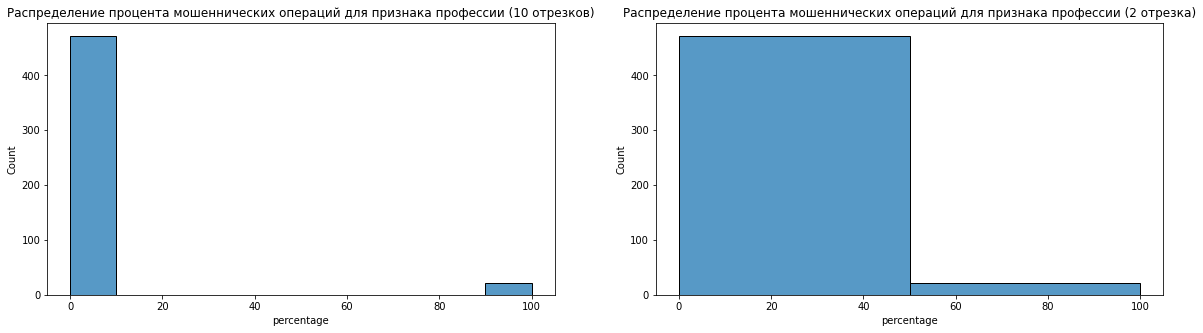

In [138]:
# Построение диаграммы для признака "job"
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
histplot_10 = sns.histplot(merged_job_grouped[merged_job_grouped.is_fraud == 1].percentage, bins=10, ax=axes[0])
axes[0].set_title('Распределение процента мошеннических операций для признака профессии (10 отрезков)')
histplot_2 = sns.histplot(merged_job_grouped[merged_job_grouped.is_fraud == 1].percentage, bins=2, ax=axes[1])
axes[1].set_title('Распределение процента мошеннических операций для признака профессии (2 отрезка)');

In [127]:
top_10_job = merged_job_grouped[merged_job_grouped.is_fraud == 1].sort_values(by='percentage', ascending=False).head(10)
top_10_job

,job,is_fraud,fraud trans_count,trans_count,percentage
444,Homeopath,1,11,11,100.0
2,"Accountant, chartered",1,11,11,100.0
393,Forest/woodland manager,1,9,9,100.0
834,Software engineer,1,11,11,100.0
827,Ship broker,1,7,7,100.0
68,Armed forces technical officer,1,8,8,100.0
228,Dancer,1,19,19,100.0
796,Sales promotion account executive,1,14,14,100.0
39,Air traffic controller,1,17,17,100.0
99,Broadcast journalist,1,9,9,100.0


По результатам анализа признака професии в зависимости от метки о мошенничестве сделаны следующие выводы:
- Для большинства профессий процент мошеннических транзакций лежит в диапазоне от 0 до 50 процентов
- Для некоторых профессий отмечается 100-процентная доля мошеннических транзакций (пример в таблице top_10_job)

Для профессий с высоким процентом мошеннических опраций необходимо принятие дополнительных мер по профилактике мошенничества.

## 3.2 Category transaction feature analysis

In [128]:
processed_data.category.describe()

count           1852394
unique               14
top       gas_transport
freq             188029
Name: category, dtype: object

In [131]:
# Анализ признака 'category'
overal_category_grouped = processed_data[['category', 'trans_num']].groupby(['category']).count().reset_index().rename(columns={'trans_num':'trans_count'})
fraud_category_grouped = processed_data[['category', 'trans_num', 'is_fraud']].groupby(['category', 'is_fraud']).count().reset_index().rename(columns={'trans_num':'fraud trans_count'})
merged_category_grouped = fraud_category_grouped.merge(overal_category_grouped, how='inner', on='category')
merged_category_grouped['percentage'] = merged_category_grouped['fraud trans_count'] / merged_category_grouped['trans_count'] * 100
merged_category_grouped

,category,is_fraud,fraud trans_count,trans_count,percentage
0,entertainment,0,133826,134118,99.782281
1,entertainment,1,292,134118,0.217719
2,food_dining,0,130524,130729,99.843187
3,food_dining,1,205,130729,0.156813
4,gas_transport,0,187257,188029,99.589425
5,gas_transport,1,772,188029,0.410575
6,grocery_net,0,64703,64878,99.730263
7,grocery_net,1,175,64878,0.269737
8,grocery_pos,0,173963,176191,98.735463
9,grocery_pos,1,2228,176191,1.264537


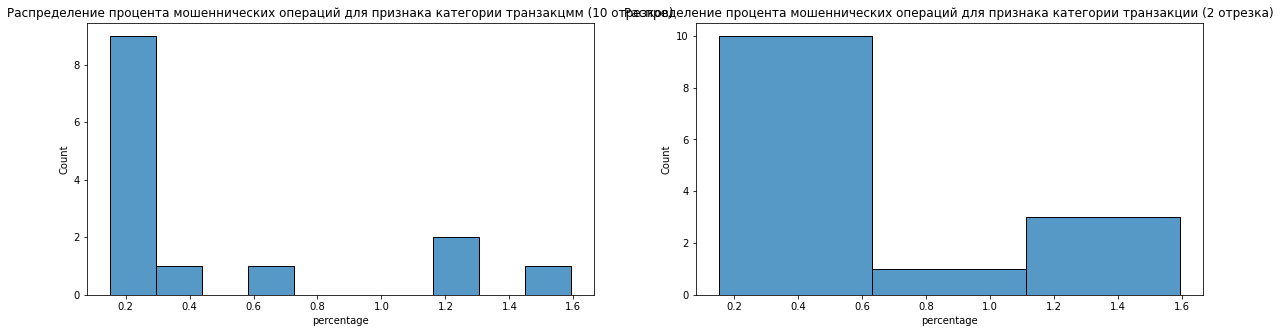

In [136]:
# Построение диаграммы для признака "category"
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
histplot_10 = sns.histplot(merged_category_grouped[merged_category_grouped.is_fraud == 1].percentage, bins=10, ax=axes[0])
axes[0].set_title('Распределение процента мошеннических операций для признака категории транзакцмм (10 отрезков)')
histplot_2 = sns.histplot(merged_category_grouped[merged_category_grouped.is_fraud == 1].percentage, bins=3, ax=axes[1])
axes[1].set_title('Распределение процента мошеннических операций для признака категории транзакции (2 отрезка)');

In [135]:
top_5_category = merged_category_grouped[merged_category_grouped.is_fraud == 1].sort_values(by='percentage', ascending=False).head(5)
top_5_category

,category,is_fraud,fraud trans_count,trans_count,percentage
23,shopping_net,1,2219,139322,1.592713
17,misc_net,1,1182,90654,1.303859
9,grocery_pos,1,2228,176191,1.264537
25,shopping_pos,1,1056,166463,0.634375
5,gas_transport,1,772,188029,0.410575


По результатам анализа признака категорий транзакций в зависимости от метки о мошенничестве сделаны следующие выводы:
- Максимальный процент мошеннических транзакций наблюдается в категории интернет покупок (1,6% от общего числа транзакций по данной категории)
- Наименьший процент мошеннических транзакций наблюдается в категории путешествий (0,27% от общего числа транзакций по данной категории)

Для категорий транзакций с высоким процентом мошеннических опраций необходимо принятие дополнительных мер по профилактике мошенничества.

## 3.2 Merchant feature analysis

In [139]:
processed_data.merchant.describe()

count               1852394
unique                  693
top       fraud_Kilback LLC
freq                   6262
Name: merchant, dtype: object

In [144]:
# Анализ признака 'merchant'
overal_merchant_grouped = processed_data[['merchant', 'trans_num']].groupby(['merchant']).count().reset_index().rename(columns={'trans_num':'trans_count'})
fraud_merchant_grouped = processed_data[['merchant', 'trans_num', 'is_fraud']].groupby(['merchant', 'is_fraud']).count().reset_index().rename(columns={'trans_num':'fraud trans_count'})
merged_merchant_grouped = fraud_merchant_grouped.merge(overal_merchant_grouped, how='inner', on='merchant')
merged_merchant_grouped['percentage'] = merged_merchant_grouped['fraud trans_count'] / merged_merchant_grouped['trans_count'] * 100
merged_merchant_grouped

,merchant,is_fraud,fraud trans_count,trans_count,percentage
0,fraud_Abbott-Rogahn,0,2643,2647,99.848886
1,fraud_Abbott-Rogahn,1,4,2647,0.151114
2,fraud_Abbott-Steuber,0,2521,2529,99.683669
3,fraud_Abbott-Steuber,1,8,2529,0.316331
4,fraud_Abernathy and Sons,0,2509,2513,99.840828
...,...,...,...,...,...
1373,fraud_Ziemann-Waters,1,10,2438,0.410172
1374,"fraud_Zieme, Bode and Dooley",0,3710,3720,99.731183
1375,"fraud_Zieme, Bode and Dooley",1,10,3720,0.268817
1376,fraud_Zulauf LLC,0,2601,2605,99.846449


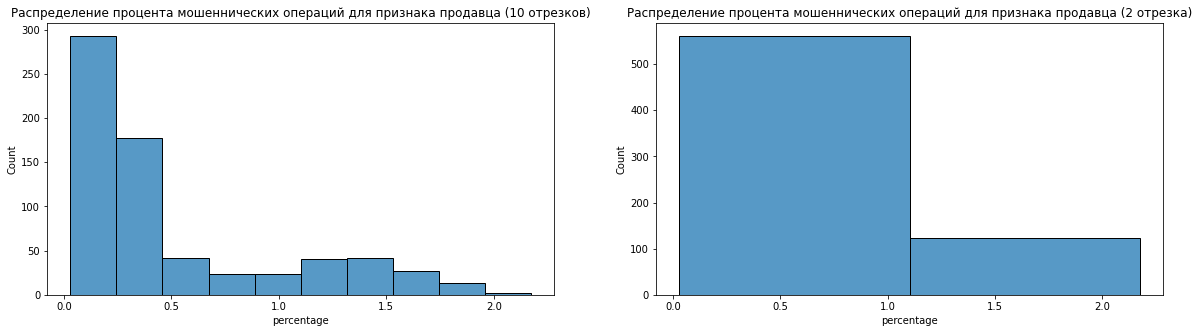

In [146]:
# Построение диаграммы для признака "merchant"
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
histplot_10 = sns.histplot(merged_merchant_grouped[merged_merchant_grouped.is_fraud == 1].percentage, bins=10, ax=axes[0])
axes[0].set_title('Распределение процента мошеннических операций для признака продавца (10 отрезков)')
histplot_2 = sns.histplot(merged_merchant_grouped[merged_merchant_grouped.is_fraud == 1].percentage, bins=2, ax=axes[1])
axes[1].set_title('Распределение процента мошеннических операций для признака продавца (2 отрезка)');

In [150]:
top_5_merchant = merged_merchant_grouped[merged_merchant_grouped.is_fraud == 1].sort_values(by='percentage', ascending=False).head(5)
top_5_merchant

,merchant,is_fraud,fraud trans_count,trans_count,percentage
673,fraud_Kozey-Boehm,1,60,2758,2.175489
490,"fraud_Herman, Treutel and Dickens",1,38,1870,2.032086
1226,fraud_Terry-Huel,1,56,2864,1.955307
607,fraud_Kerluke-Abshire,1,50,2635,1.897533
884,"fraud_Mosciski, Ziemann and Farrell",1,53,2821,1.878766


In [152]:
display('Количество продавцов, для которых наблюдается более 1% мошеннических операций:')
display(merged_merchant_grouped[(merged_merchant_grouped.is_fraud == 1) & (merged_merchant_grouped['percentage'] >= 1)].shape[0])

'Количество продавцов, для которых наблюдается более 1% мошеннических операций:'

139

По результатам анализа признака наименований продавца в зависимости от метки о мошенничестве сделаны следующие выводы:
- Максимальный процент мошеннических транзакций наблюдается у продавца fraud_Kozey-Boehm (2,2% от общего числа транзакций по данному продавцу)
- Для 139 продавцов наблюдается процент мошеннических операций преващающий 1% от общего числа транзакций по данным продавцам

Для продавцов с высоким процентом мошеннических опраций необходимо принятие дополнительных мер по профилактике мошенничества.

## 3.2 Transaction time feature analysis

In [156]:
# Анализ признака 'trans_month_of_year'
overal_month_grouped = processed_data[['trans_month_of_year', 'trans_num']].groupby(['trans_month_of_year']).count().reset_index().rename(columns={'trans_num':'trans_count'})
fraud_month_grouped = processed_data[['trans_month_of_year', 'trans_num', 'is_fraud']].groupby(['trans_month_of_year', 'is_fraud']).count().reset_index().rename(columns={'trans_num':'fraud trans_count'})
merged_month_grouped = fraud_month_grouped.merge(overal_month_grouped, how='inner', on='trans_month_of_year')
merged_month_grouped['percentage'] = merged_month_grouped['fraud trans_count'] / merged_month_grouped['trans_count'] * 100
merged_month_grouped

,trans_month_of_year,is_fraud,fraud trans_count,trans_count,percentage
0,1,0,103878,104727,99.189321
1,1,1,849,104727,0.810679
2,2,0,96804,97657,99.126535
3,2,1,853,97657,0.873465
4,3,0,142851,143789,99.347655
5,3,1,938,143789,0.652345
6,4,0,134292,134970,99.497666
7,4,1,678,134970,0.502334
8,5,0,145940,146875,99.363404
9,5,1,935,146875,0.636596


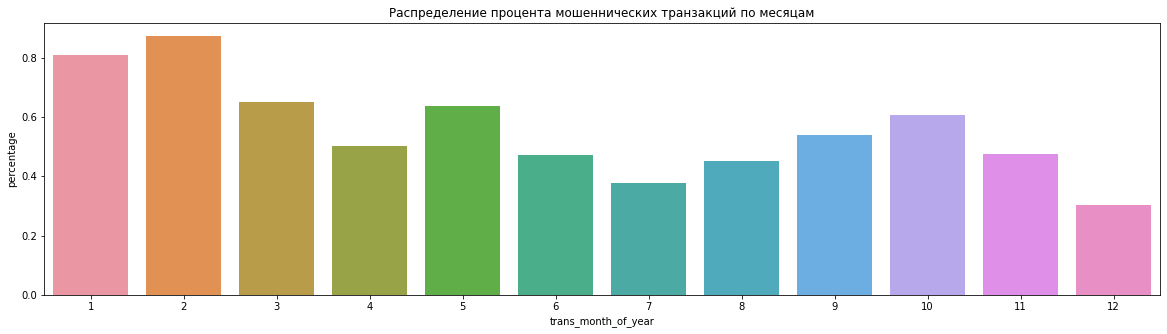

In [171]:
# Построение гистораммы для признака месяца совершения транзакции
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

histplot = sns.barplot(data=merged_month_grouped[merged_month_grouped.is_fraud == 1], x='trans_month_of_year', y='percentage')
histplot.set_title('Распределение процента мошеннических транзакций по месяцам');

In [172]:
# Анализ признака 'trans_day_of_week'
overal_day_grouped = processed_data[['trans_day_of_week', 'trans_num']].groupby(['trans_day_of_week']).count().reset_index().rename(columns={'trans_num':'trans_count'})
fraud_day_grouped = processed_data[['trans_day_of_week', 'trans_num', 'is_fraud']].groupby(['trans_day_of_week', 'is_fraud']).count().reset_index().rename(columns={'trans_num':'fraud trans_count'})
merged_day_grouped = fraud_day_grouped.merge(overal_day_grouped, how='inner', on='trans_day_of_week')
merged_day_grouped['percentage'] = merged_day_grouped['fraud trans_count'] / merged_day_grouped['trans_count'] * 100
merged_day_grouped

,trans_day_of_week,is_fraud,fraud trans_count,trans_count,percentage
0,0,0,367934,369418,99.598287
1,0,1,1484,369418,0.401713
2,1,0,269074,270340,99.531701
3,1,1,1266,270340,0.468299
4,2,0,182788,183913,99.388298
5,2,1,1125,183913,0.611702
6,3,0,205424,206741,99.362971
7,3,1,1317,206741,0.637029
8,4,0,213702,215078,99.360232
9,4,1,1376,215078,0.639768


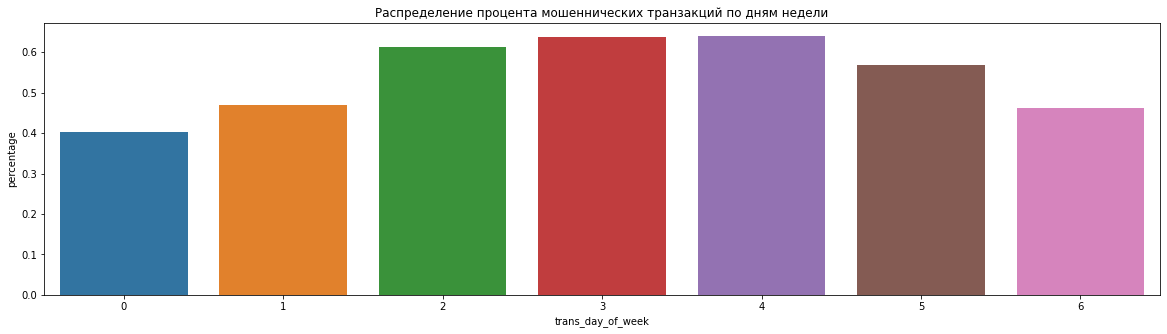

In [173]:
# Построение гистораммы для признака дня недели совершения транзакции
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

histplot = sns.barplot(data=merged_day_grouped[merged_day_grouped.is_fraud == 1], x='trans_day_of_week', y='percentage')
histplot.set_title('Распределение процента мошеннических транзакций по дням недели');

In [174]:
# Анализ признака 'trans_hour'
overal_hour_grouped = processed_data[['trans_hour', 'trans_num']].groupby(['trans_hour']).count().reset_index().rename(columns={'trans_num':'trans_count'})
fraud_hour_grouped = processed_data[['trans_hour', 'trans_num', 'is_fraud']].groupby(['trans_hour', 'is_fraud']).count().reset_index().rename(columns={'trans_num':'fraud trans_count'})
merged_hour_grouped = fraud_hour_grouped.merge(overal_hour_grouped, how='inner', on='trans_hour')
merged_hour_grouped['percentage'] = merged_hour_grouped['fraud trans_count'] / merged_hour_grouped['trans_count'] * 100

,trans_hour,is_fraud,fraud trans_count,trans_count,percentage
0,0,0,59832,60655,98.643146
1,0,1,823,60655,1.356854
2,1,0,60503,61330,98.651557
3,1,1,827,61330,1.348443
4,2,0,60003,60796,98.695638
5,2,1,793,60796,1.304362
6,3,0,60165,60968,98.682916
7,3,1,803,60968,1.317084
8,4,0,59877,59938,99.898228
9,4,1,61,59938,0.101772


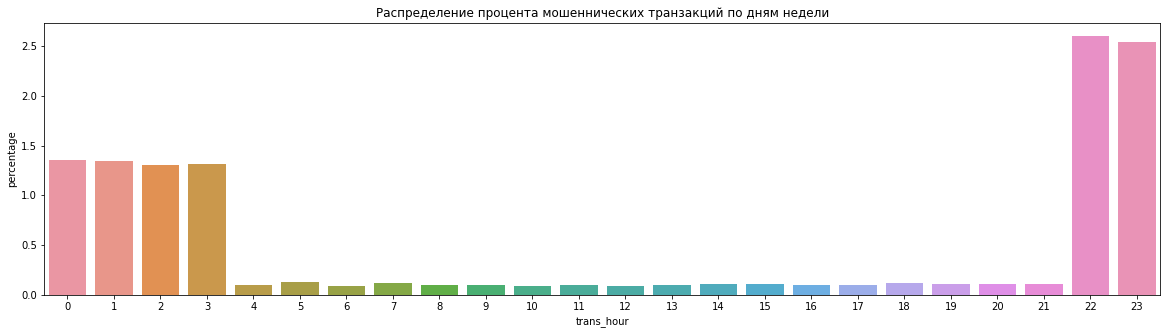

In [175]:
# Построение гистораммы для признака часа совершения транзакции
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

histplot = sns.barplot(data=merged_hour_grouped[merged_hour_grouped.is_fraud == 1], x='trans_hour', y='percentage')
histplot.set_title('Распределение процента мошеннических транзакций по дням недели');

По результатам анализа признака времени совершения транзакции от метки о мошенничестве сделаны следующие выводы:
- Максимальный процент мошеннических транзакций наблюдается у продавца fraud_Kozey-Boehm (2,2% от общего числа транзакций по данному продавцу)
- Для 139 продавцов наблюдается процент мошеннических операций преващающий 1% от общего числа транзакций по данным продавцам

Для продавцов с высоким процентом мошеннических опраций необходимо принятие дополнительных мер по профилактике мошенничества.

In [116]:
# Выполнение теста на нормальность
# Формулировка нулевой и альтернативной гипотез
H0 = 'Распределение признака price_log является нормальным'
H1 = 'Распределение признака price_log отлично от нормального'

# Уровень значимости
alpha = 0.05

# Выполнение теста Д'Агостино
d_agostino = stats.normaltest(price_filtred_data['price_log'])

if d_agostino.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

Отвергаем нулевую гипотезу. Распределение признака price_log является нормальным
Альтернативная гипотеза. H1: Распределение признака price_log отлично от нормального
